In [1]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=dc491865a37aed371c21cd0f71bcc9b9e88d510e581e3af0640b605181994eb2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, max, min
from pyspark.sql.types import FloatType
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import VectorAssembler

In [3]:
spark = SparkSession.builder.appName('Lab').getOrCreate()

1. Прочитайте CSV файл spark.read.csv()

In [7]:
df = spark.read.csv("bestsellers with categories.csv", header=True, inferSchema=True)

2. Вивести схему даних за допомогою PrintSchema.

In [8]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



3. Вивести назви стовпців і типи даних за допомогою dtypes

In [9]:
df.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'double'),
 ('Reviews', 'int'),
 ('Price', 'int'),
 ('Year', 'int'),
 ('Genre', 'string')]

4. Виведіть перші п'ять рядків (використовується метод head)

In [10]:
df.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating=4.6, Reviews=2052, Price=22, Year=2011, Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating=4.7, Reviews=18979, Price=15, Year=2018, Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating=4.7, Reviews=21424, Price=6, Year=2017, Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating=4.8, Reviews=7665, Price=12, Year=2019, Genre='Non Fiction')]

5. Вивести перший рядок за допомогою first()

In [11]:
df.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction')

6. Зробіть опис датасету за допомогою describe()

In [12]:
df.describe()

DataFrame[summary: string, Name: string, Author: string, User Rating: string, Reviews: string, Price: string, Year: string, Genre: string]

7. Виведіть список стовпців за допомогою columns()

In [13]:
df.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

8. Виведіть загальну кількість рядків даних за допомогою count()

In [14]:
df.count()

550

9. Перевірте, чи у всіх рядків вистачає даних. Якщо є пропуски, замінить їх на NaN, потім тип даних на числовий

In [18]:
df.dropna().count()

# Датасет не містить пропуски

550

10. Замініть комірки з пропущеними значенями на середні за стовпцем. І тип даних на float. Про скільки книг зберігає дані датасет?

In [19]:
# пропусків немає

In [21]:
books = df.count()
print(f"Датасет містить інформацію про {books} книжок.")

Датасет містить інформацію про 550 книжок.


11. Змініть назви всіх колонок: назва з маленької букви, без пробілів через підкреслення.
12.
df.columns = ['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre']

In [26]:
new_col_names = [col(column).alias(column.lower().replace(' ', '_')) for column in df.columns]
df = df.select(*new_col_names)

df.show(5)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                name|              author|user_rating|reviews|price|year|      genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
only showing top 5 rows



13. Знайдіть автора з найвищим рейтингом

In [28]:
highest_rating_author = (
    df
    .groupBy("author")
    .agg(max("user_rating").alias("max_rating"))
    .orderBy(col("max_rating").desc())
    .limit(1)
)

highest_rating_author.show()

+-----------+----------+
|     author|max_rating|
+-----------+----------+
|Sarah Young|       4.9|
+-----------+----------+



14. Знайдіть автора з найнижчим рейтингом.

In [32]:
lowest_rating_author = (
    df
    .groupBy("author")
    .agg(min("user_rating").alias("min_rating"))
    .orderBy(col("min_rating").asc())
    .limit(1)
)

lowest_rating_author.show()

+------------+----------+
|      author|min_rating|
+------------+----------+
|J.K. Rowling|       3.3|
+------------+----------+



15. Знайдіть автора, що має найбільшу кількіть рецензій.

In [33]:
max_reviews_author = (
    df
    .groupBy("author")
    .agg(max("reviews").alias("max_reviews"))
    .orderBy(col("max_reviews").desc())
    .limit(1)
)

max_reviews_author.show()

+-----------+-----------+
|     author|max_reviews|
+-----------+-----------+
|Delia Owens|      87841|
+-----------+-----------+



16. Побуду йте гістограму ре йтингу 10 найкращих книг (відібрати книги з
найбільшим рейтингом).

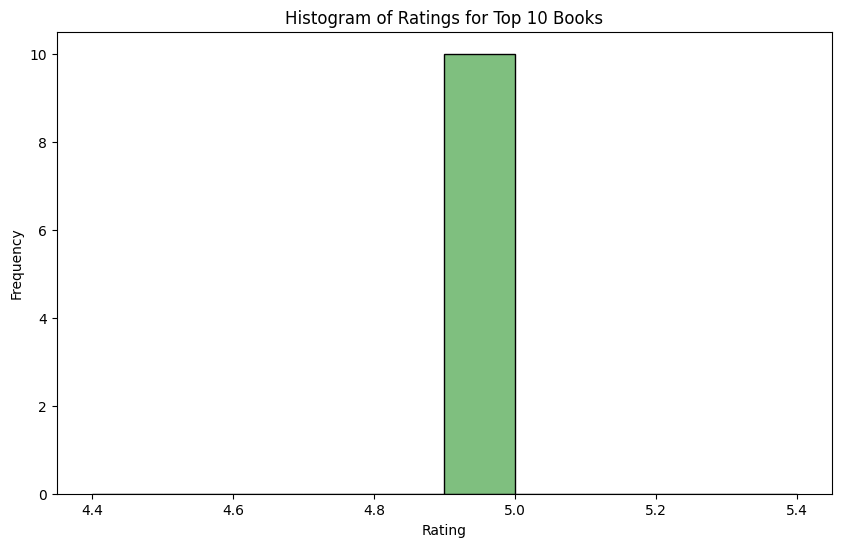

In [35]:
top_10_books = (
    df
    .orderBy(col("user_rating").desc())
    .limit(10)
)

top_10_books_pd = top_10_books.toPandas()

plt.figure(figsize = (10, 6))
sns.histplot(top_10_books_pd['user_rating'], bins = 10, kde = True, color = 'green')
plt.title('Histogram of Ratings for Top 10 Books')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


17. Побуду йте матрицю к ореляції для стовпчиків user_rating', 'reviews',
'

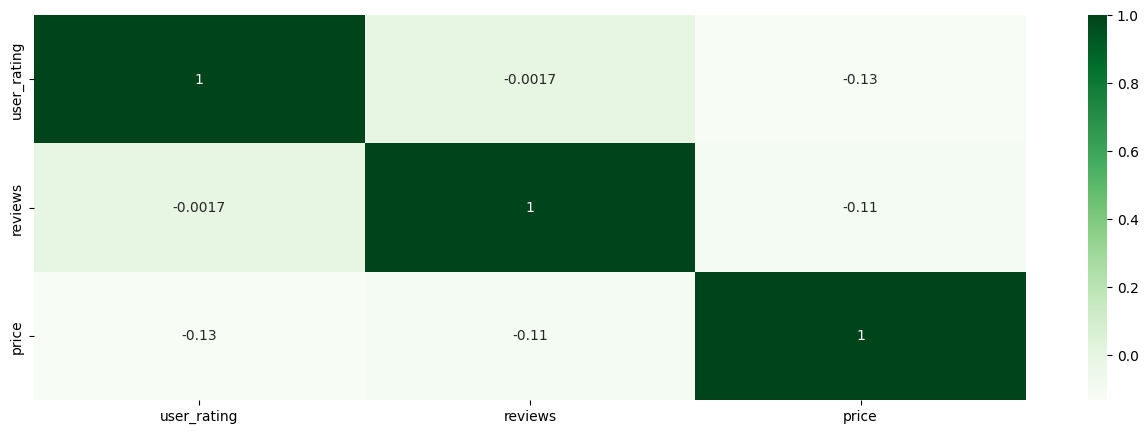

In [37]:
columns       = ['user_rating', 'reviews', 'price']
selected_data = df.select(columns)

assembler     = VectorAssembler(inputCols = columns, outputCol = "features")
selected_data = assembler.transform(selected_data)

matrix      = Correlation.corr(selected_data, 'features').collect()[0][0]
corr_matrix = matrix.toArray().tolist()

corr_matrix_df = pd.DataFrame(data = corr_matrix, columns = columns, index = columns)

for col in columns:
    corr_matrix_df[col] = corr_matrix_df[col].astype(float)

plt.figure(figsize=(16, 5))
sns.heatmap(corr_matrix_df,
            xticklabels = corr_matrix_df.columns.values,
            yticklabels = corr_matrix_df.columns.values, cmap = "Greens", annot = True)
plt.show()